In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import botorch
import gpytorch
from tqdm import tqdm

In [2]:
# set torch random seed
torch.manual_seed(2)

## Utilities and GPModel class

In [3]:
def forrester_1d(x):
    # a modification of https://www.sfu.ca/~ssurjano/forretal08.html
    y = -((x + 1) ** 2) * torch.sin(2 * x + 2) / 5 + 1
    return y.squeeze(-1)

In [4]:
def visualize_gp_belief_and_policy(train_x, xs, model, likelihood, policy=None, next_x=None):
    train_y, ys = forrester_1d(train_x), forrester_1d(xs)
    with torch.no_grad():
        predictive_distribution = likelihood(model(xs))
        predictive_mean = predictive_distribution.mean
        predictive_upper, predictive_lower = predictive_distribution.confidence_region()

        if policy is not None:
            acquisition_score = policy(xs.unsqueeze(1))

    if policy is None:
        plt.figure(figsize=(8, 3))

        plt.plot(xs, ys, label="objective", c="r")
        plt.scatter(train_x, train_y, marker="x", c="k", label="observations")

        plt.plot(xs, predictive_mean, label="mean")
        plt.fill_between(
            xs.flatten(), predictive_upper, predictive_lower, alpha=0.3, label="95\% CI"
        )

        plt.legend()
        plt.show()
    else:
        fig, ax = plt.subplots(
            2, 1, figsize=(8, 6), sharex=True, gridspec_kw={"height_ratios": [2, 1]}
        )

        # GP belief
        ax[0].plot(xs, ys, label="objective", c="r")
        ax[0].scatter(train_x, train_y, marker="x", c="k", label="observations")

        ax[0].plot(xs, predictive_mean, label="mean")
        ax[0].fill_between(
            xs.flatten(), predictive_upper, predictive_lower, alpha=0.3, label="95% CI"
        )

        if next_x is not None:
            ax[0].axvline(next_x.item(), linestyle="dotted", c="k")

        ax[0].legend()
        ax[0].set_ylabel("predictive")

        # acquisition score
        ax[1].plot(xs, acquisition_score, c="g")
        ax[1].fill_between(xs.flatten(), acquisition_score, 0, color="g", alpha=0.5)

        if next_x is not None:
            ax[1].axvline(next_x.item(), linestyle="dotted", c="k")

        ax[1].set_ylabel("acquisition score")

        plt.show()

In [5]:
class GPModel(gpytorch.models.ExactGP, botorch.models.gpytorch.GPyTorchModel):
    _num_outputs = 1

    def __init__(self, train_x, train_y, likelihood, likelihood_noise=1e-4):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        self.likelihood.noise = likelihood_noise

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [6]:
def fit_gp_model(train_x, train_y, num_train_iters=500):
    # declare the GP
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = GPModel(train_x, train_y, likelihood)
    
    # train the hyperparameter (the constant)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    model.train()
    likelihood.train()

    for i in tqdm(range(num_train_iters)):
        optimizer.zero_grad()

        output = model(train_x)
        loss = -mll(output, train_y)

        loss.backward()
        optimizer.step()

    model.eval()
    likelihood.eval()

    return model, likelihood

## Set-up the data

In [7]:
bound = 5

xs = torch.linspace(-bound, bound, bound * 100 + 1).unsqueeze(1)
ys = forrester_1d(xs)

torch.manual_seed(2)
train_x = torch.tensor([[1.0], [2.0]])
train_y = forrester_1d(train_x)

## Fit and visualize GP model

In [8]:
model, likelihood = fit_gp_model(train_x, train_y)

100%|██████████| 500/500 [00:00<00:00, 690.79it/s]


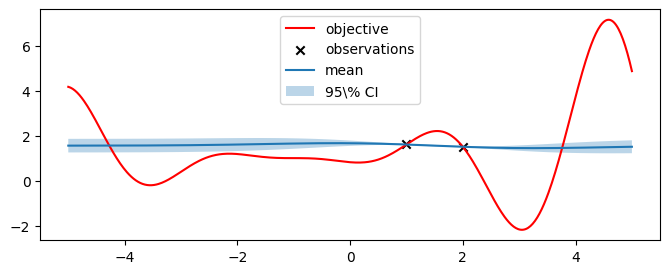

In [9]:
visualize_gp_belief_and_policy(train_x, xs, model, likelihood)

## Explore PoI with epsilon

### Absolute epsilon

iteration 0
incumbent tensor([1.]) tensor(1.6054)


100%|██████████| 500/500 [00:00<00:00, 638.83it/s]


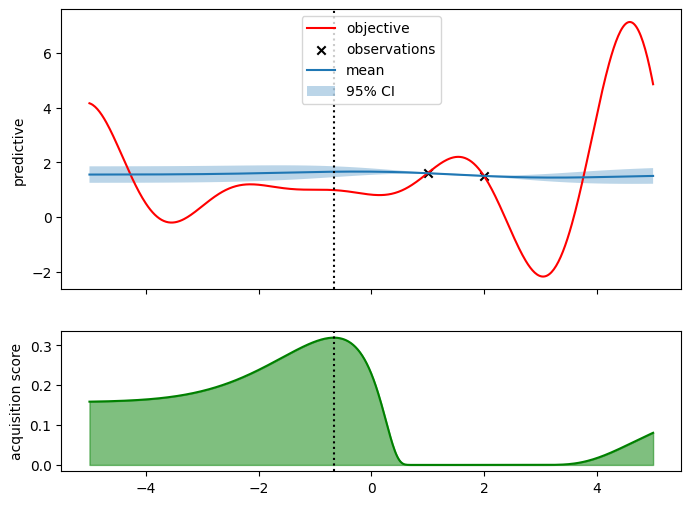

iteration 1
incumbent tensor([1.]) tensor(1.6054)


100%|██████████| 500/500 [00:00<00:00, 622.29it/s]


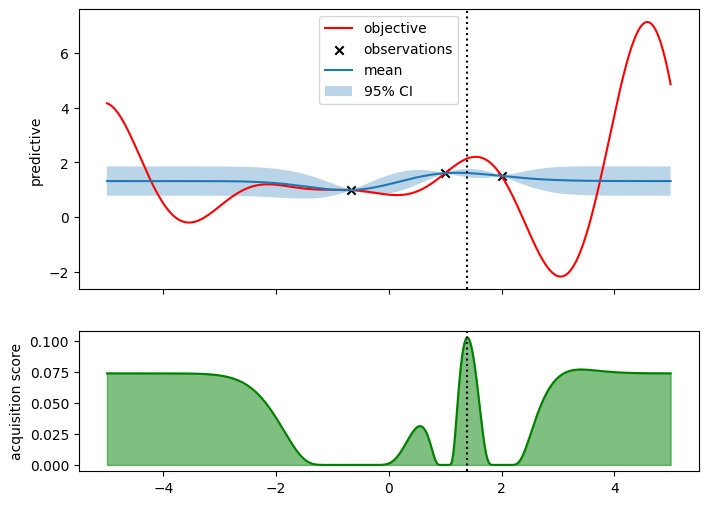

iteration 2
incumbent tensor([1.3939]) tensor(2.1429)


100%|██████████| 500/500 [00:00<00:00, 740.39it/s]


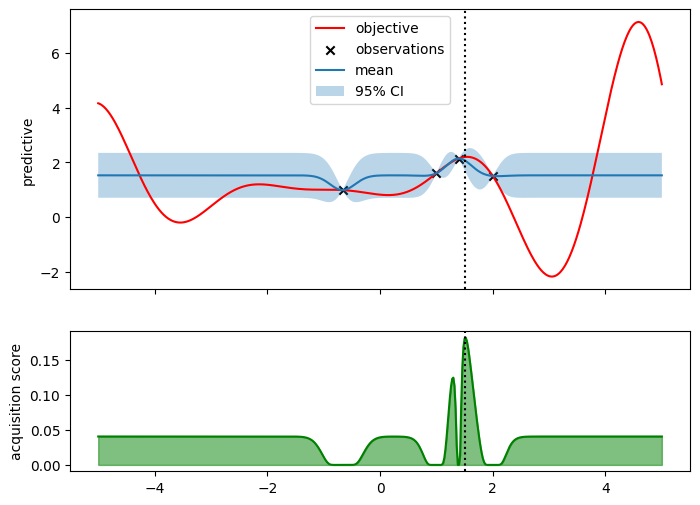

iteration 3
incumbent tensor([1.5134]) tensor(2.2015)


100%|██████████| 500/500 [00:00<00:00, 749.14it/s]


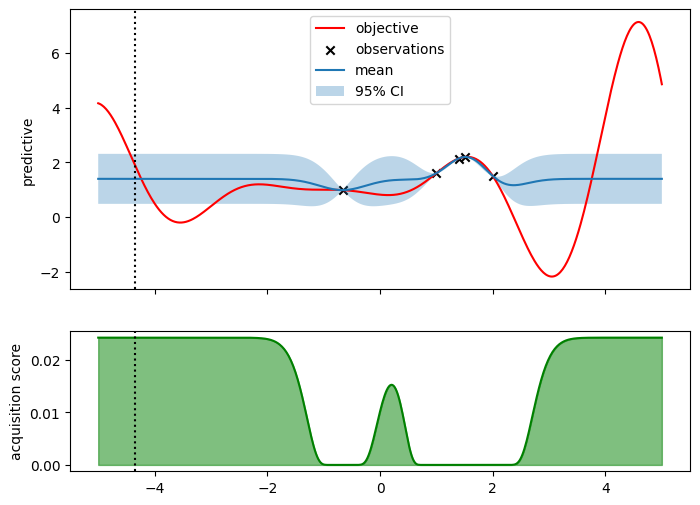

iteration 4
incumbent tensor([1.5134]) tensor(2.2015)


100%|██████████| 500/500 [00:00<00:00, 673.62it/s]


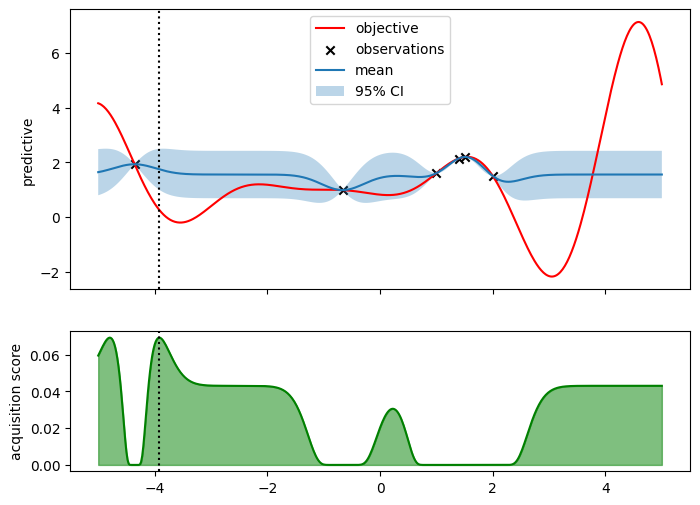

iteration 5
incumbent tensor([1.5134]) tensor(2.2015)


100%|██████████| 500/500 [00:00<00:00, 724.22it/s]


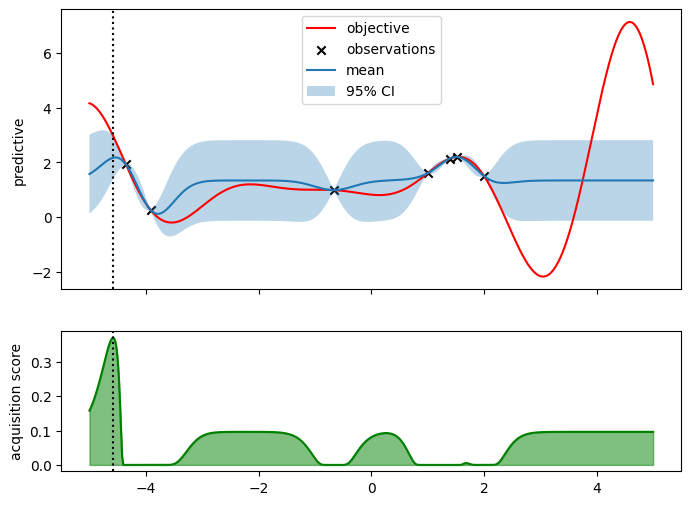

iteration 6
incumbent tensor([-4.5811]) tensor(2.9752)


100%|██████████| 500/500 [00:00<00:00, 766.71it/s]


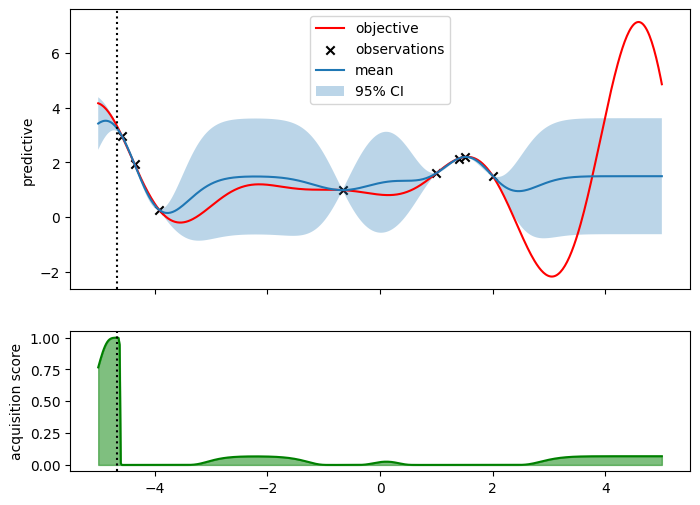

iteration 7
incumbent tensor([-4.6728]) tensor(3.3567)


100%|██████████| 500/500 [00:00<00:00, 632.47it/s]


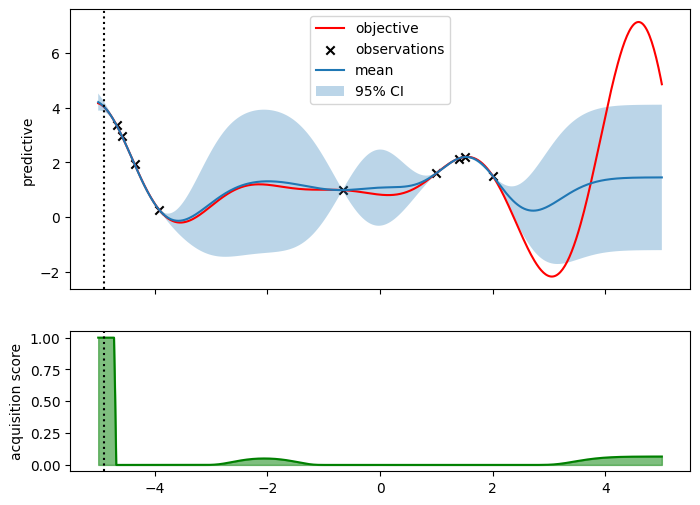

iteration 8
incumbent tensor([-4.9007]) tensor(4.0388)


100%|██████████| 500/500 [00:00<00:00, 718.89it/s]


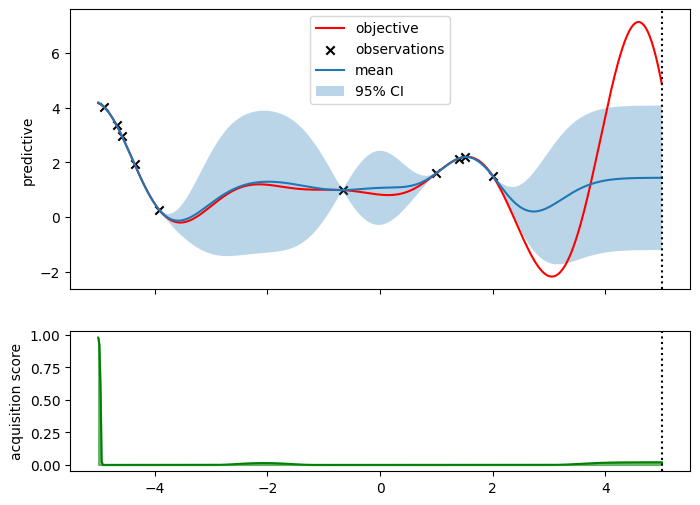

iteration 9
incumbent tensor([5.]) tensor(4.8633)


100%|██████████| 500/500 [00:00<00:00, 617.92it/s]


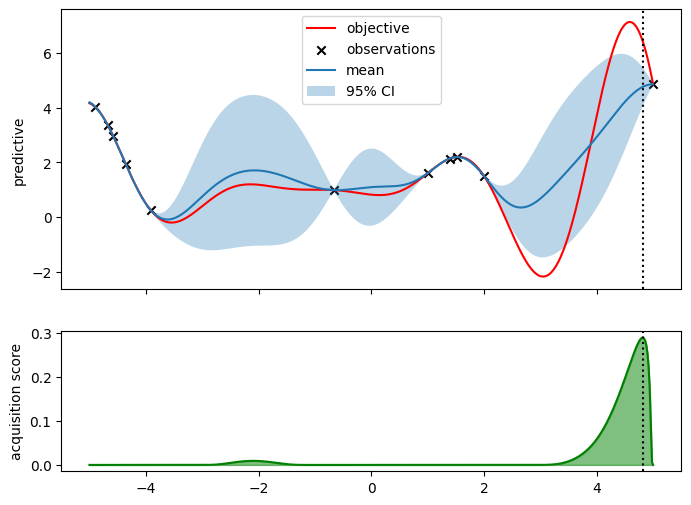

In [10]:
epsilon = 0.1
num_queries = 10

for i in range(num_queries):
    print("iteration", i)
    print("incumbent", train_x[train_y.argmax()], train_y.max())

    model, likelihood = fit_gp_model(train_x, train_y)

    policy = botorch.acquisition.analytic.ProbabilityOfImprovement(
        model, best_f=train_y.max() + epsilon
    )

    next_x, acq_val = botorch.optim.optimize_acqf(
        policy,
        bounds=torch.tensor([[-bound * 1.0], [bound * 1.0]]),
        q=1,
        num_restarts=20,
        raw_samples=50,
    )

    visualize_gp_belief_and_policy(train_x, xs, model, likelihood, policy=policy, next_x=next_x)

    next_y = forrester_1d(next_x)

    train_x = torch.cat([train_x, next_x])
    train_y = torch.cat([train_y, next_y])

### Relative epsilon in PoI

iteration 0
incumbent tensor([4.8148]) tensor(6.4480)


100%|██████████| 500/500 [00:00<00:00, 637.02it/s]


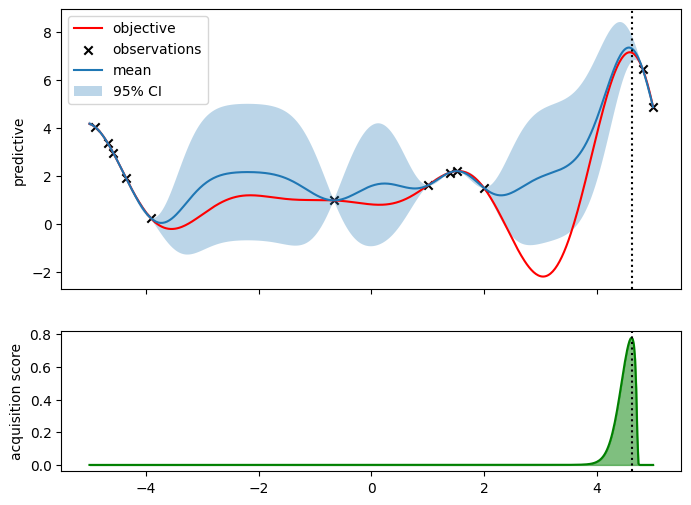

iteration 1
incumbent tensor([4.6183]) tensor(7.1306)


100%|██████████| 500/500 [00:00<00:00, 695.37it/s]


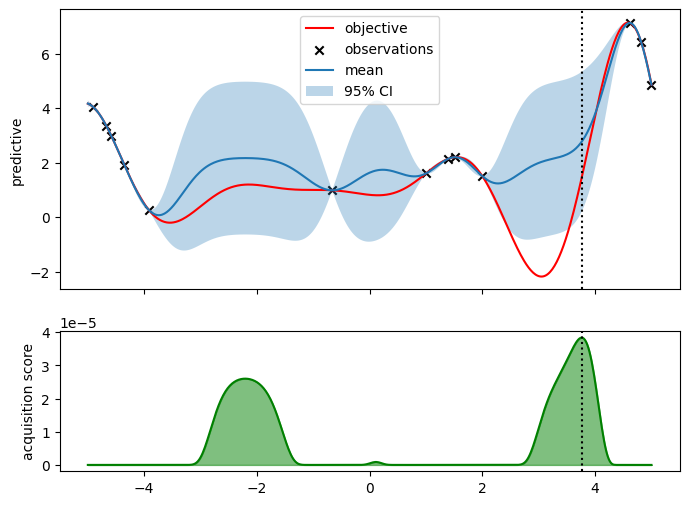

iteration 2
incumbent tensor([4.6183]) tensor(7.1306)


100%|██████████| 500/500 [00:00<00:00, 630.70it/s]


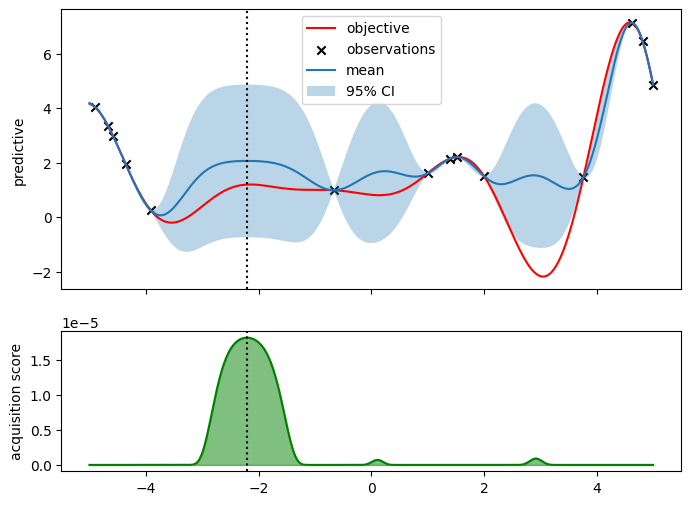

iteration 3
incumbent tensor([4.6183]) tensor(7.1306)


100%|██████████| 500/500 [00:00<00:00, 719.24it/s]


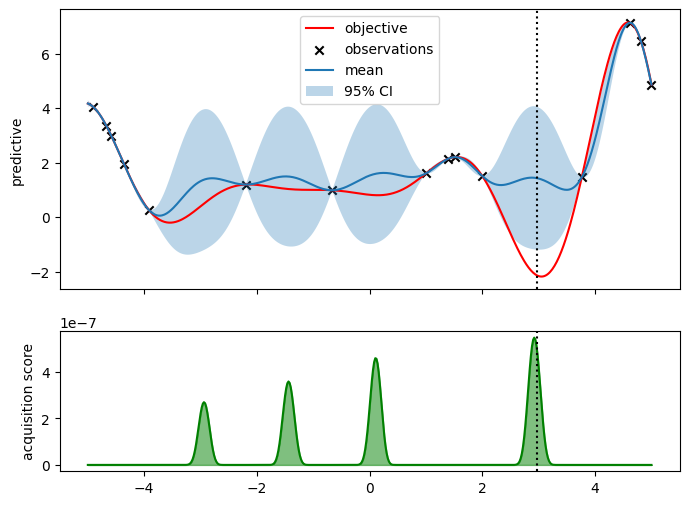

iteration 4
incumbent tensor([4.6183]) tensor(7.1306)


100%|██████████| 500/500 [00:00<00:00, 630.35it/s]


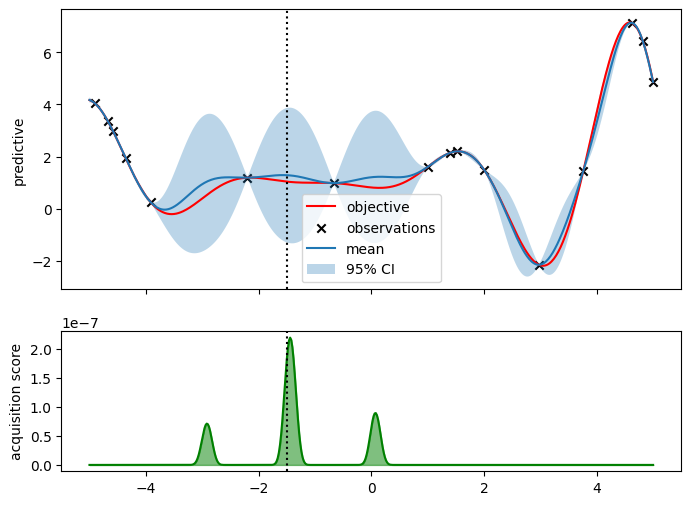

iteration 5
incumbent tensor([4.6183]) tensor(7.1306)


100%|██████████| 500/500 [00:00<00:00, 564.09it/s]


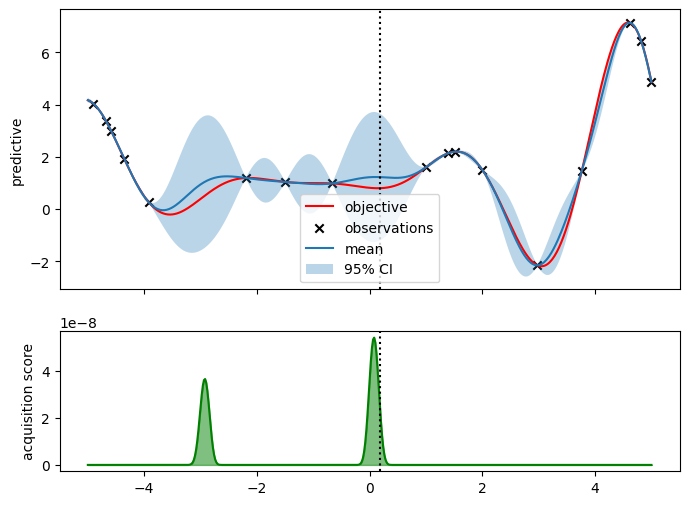

iteration 6
incumbent tensor([4.6183]) tensor(7.1306)


100%|██████████| 500/500 [00:00<00:00, 564.39it/s]


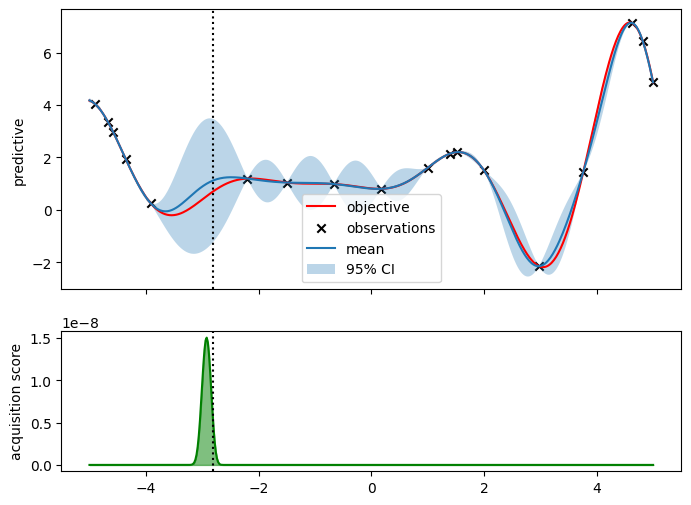

iteration 7
incumbent tensor([4.6183]) tensor(7.1306)


100%|██████████| 500/500 [00:00<00:00, 553.91it/s]


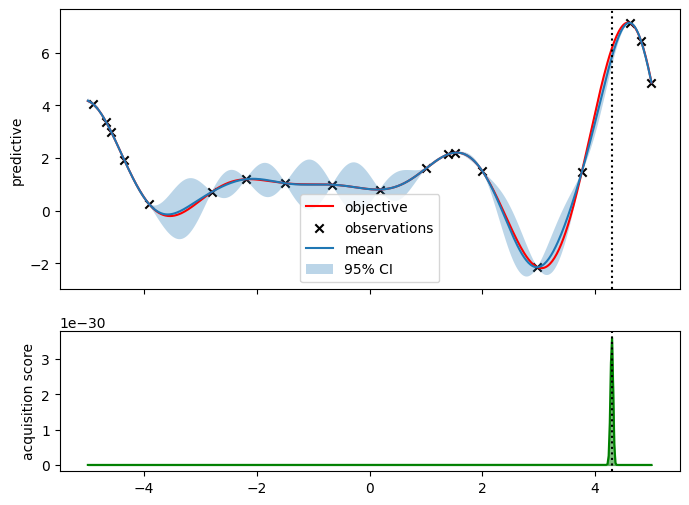

iteration 8
incumbent tensor([4.6183]) tensor(7.1306)


100%|██████████| 500/500 [00:00<00:00, 529.79it/s]
/home/vscode/.local/lib/python3.10/site-packages/botorch/optim/initializers.py:432: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


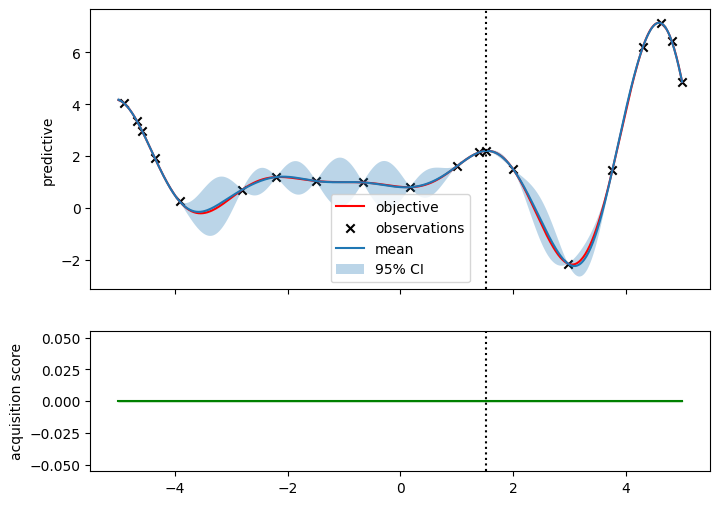

iteration 9
incumbent tensor([4.6183]) tensor(7.1306)


100%|██████████| 500/500 [00:00<00:00, 506.39it/s]
/home/vscode/.local/lib/python3.10/site-packages/botorch/optim/initializers.py:432: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


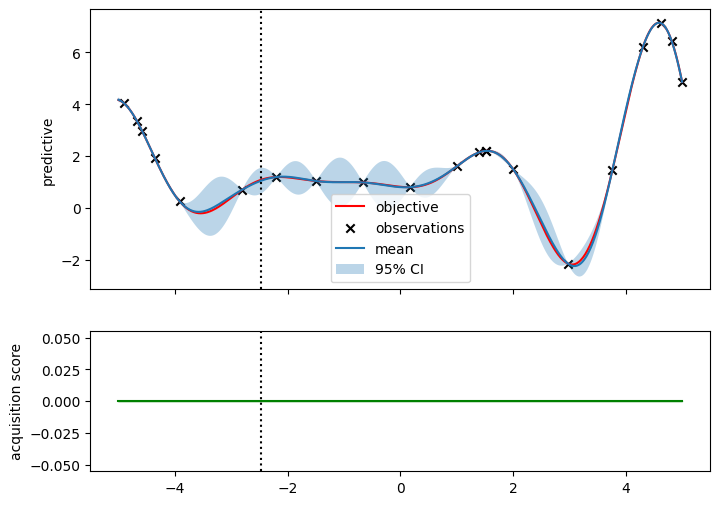

In [11]:
epsilon_pct = 0.1
num_queries = 10

for i in range(num_queries):
    print("iteration", i)
    print("incumbent", train_x[train_y.argmax()], train_y.max())

    model, likelihood = fit_gp_model(train_x, train_y)

    policy = botorch.acquisition.analytic.ProbabilityOfImprovement(
        model, best_f=train_y.max() * (1 + epsilon_pct)
    )

    next_x, acq_val = botorch.optim.optimize_acqf(
        policy,
        bounds=torch.tensor([[-bound * 1.0], [bound * 1.0]]),
        q=1,
        num_restarts=20,
        raw_samples=50,
    )

    visualize_gp_belief_and_policy(train_x, xs, model, likelihood, policy=policy, next_x=next_x)

    next_y = forrester_1d(next_x)

    train_x = torch.cat([train_x, next_x])
    train_y = torch.cat([train_y, next_y])